# An Analysis Of The Current Music Critic Landscape
by Nathan Kaplan

The job of a music critic is to review notable music as it becomes released by the artist. Music fans tend to use critics' reviews 1) to determine what to listen to and 2) as a centerpiece for discussing and debating music. As a result, a positive review can have a big effect on a band's commercial success. Over the past ten years bands like Death Grips, Brockhampton, Daughters, and Spellling have all been propelled to commercial success by positive reviews from critics. On the other side of the coin, negative reviews can be detrimental to a band's success. Pitchfork, a large music publication, infamously reviewed the 2006 album Shine On by Jet [by just embedding a video of a monkey peeing into its own mouth](https://pitchfork.com/reviews/albums/9464-shine-on/). The album did not sell well, and although it's impossible to measure, Jet undoubtedly lost a significant number of fans. 

Given the role of music critics and the subjective nature of music reviewing, it is in the interest of fans and artists to know how different music publications review music differently. In this project, I will be analyzing the differences between several publications' top-songs-of-the-year lists. 


The music critic landscape is incredibly varied, and each publication is known for having certain biases. Here is an overview of some of the major critic publications that we will be looking at in this tutorial:
* The most popular music critic today seems to be Anthony Fantano, who has been releasing video reviews of new albums under his Youtube channel **The Needle Drop** since 2014 and has amassed over 2.5 million subscribers. Those who are critical of Fantano say that he is biased toward experimental music, and doesn't give certain well-liked albums a chance. Fantano's top-songs-of-the-year list is also only 50 songs long as opposed to the other publications which list 100.
* One of the historically most popular music critic publications that still has a strong following today is the aforementioned **Pitchfork**. In contrast to Fantano, Pitchfork is made up of a team of music reviewers who release written music reviews. Pitchfork is criticized for retroactively changing their reviews to correspond with the opinions of music fans. 
* The website rateyourmusic.com (abbreviated **RYM**), is a large forum for music fans to rate, review, and discuss music. This forum may also be viewed as a critic publication representing the views of music fans. The RYM ecosystem is criticized for being overly contrarian and rating small experimental songs over bigger well-liked ones. This may be exacerbated by the fact that people typically don't rate music that they don't listen to, and so well-liked songs from extremely niche genres rise to the top. RYM is also different from the other publications in that its top-song-of-the-year list changes well after the year ends as people continue to use the website. 
* We can also view the general US public as a collective critic, who rates songs by listening to them more or less. In contrast to the music on RYM, the music listened to the most by the wider public is criticized for being overly homogenous and inoffensive. The songs listened to the most by the US public are compiled by the organization **Billboard** every year. 

## Data collection/curation + parsing 

The first thing we need to do is collect and parse our data. We will be using the Spotipy library, which is a user-friendly Python library to interact with the Spotify API and obtain audio features that have been pre-computed by Spotify. You can learn more about Spotipy [here](https://spotipy.readthedocs.io/en/2.19.0/). To get additional data about the artist, we will be cross-listing the Spotify data with a music database called MusicBrainz. You can learn more about MusicBrainz [here](https://musicbrainz.org/). The first step here is to import our libraries and connect to both Spotify and MusicBrainz. Spotify requires a public and secret developer key-- I store mine in a separate text file but you can get your own by creating a developer account [here](https://developer.spotify.com/dashboard/application).


In [1]:
%%capture
import os
os.system('pip install spotipy | (grep -v \'Requirement already satisfied\' 1>&2)')
os.system('pip install musicbrainzngs | (grep -v \'Requirement already satisfied\' 1>&2)')
import spotipy
from spotipy.oauth2 import SpotifyOAuth
from spotipy.oauth2 import SpotifyClientCredentials
import numpy as np
import pandas as pd
import musicbrainzngs
import math
from datetime import date,time,datetime,timedelta
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.weightstats import ztest
with open("../Spotify_keys.txt","r+") as file:
    client_id=file.readline()
    client_secret=file.readline()
    
%env SPOTIPY_CLIENT_ID=client_id
%env SPOTIPY_CLIENT_SECRET=client_secret
musicbrainzngs.set_useragent("Critic Analyzer", "1.0")
sp = spotipy.Spotify(client_credentials_manager=SpotifyClientCredentials())

Below are listed three functions that collectively will extract our data and format it so that it may be imported into a dataframe

In [2]:
#Return spotify song information given list of playlist uris
def get_spotify_info(uri):
    
    #Get song uri's
    songs=sp.playlist_items(uri);
    track_names=[song['track']['name'] for song in songs['items']]
    uris=[songs['items'][i]['track']['uri'] for i in range(len(songs['items']))]
    
    #Get song and artist features
    popularity=[songs['items'][i]['track']['popularity'] for i in range(len(songs['items']))] 
    features=list(sp.audio_features(tracks=uris))
    num_artists=[len(songs['items'][i]['track']['artists']) for i in range(len(songs['items']))]
    artist_names=[[songs['items'][i]['track']['artists'][j]['name'] for j in range(num_artists[i])] for i in range(len(songs['items']))]
    artist_uris=[[songs['items'][i]['track']['artists'][j]['uri'] for j in range(num_artists[i])] for i in range(len(songs['items']))]
    artist_genres=[set() for i in range(len(track_names))]
    
    for i in range(len(track_names)):
        for j in range(len(artist_uris[i])):
            artist_genres[i].update(sp.artist(artist_uris[i][j])['genres'])
            
    return track_names,popularity,features,num_artists,artist_names,artist_genres

#Return musicbrainz artist information given list of artists associated with each track
def get_musicbrainz_info(artist_names,track_names):
    
    #Get artist and artist info
    mb_artist_info=[[musicbrainzngs.search_artists(query=artist, limit=1)['artist-list'][0] for artist in artist_list] for artist_list in artist_names]
    artist_genders=[[] for i in range(len(track_names))]
    artist_born=[[] for i in range(len(track_names))]
    group_started=[[] for i in range(len(track_names))]
    artist_countries=[[] for i in range(len(track_names))]
    
    #Get features from each artist
    for i in range(len(track_names)):
        for j in range(len(artist_names[i])):
            gender=mb_artist_info[i][j].get('gender');
            
            #Extract gender (or group)
            if gender is not None:
                artist_genders[i].append(gender[0])
                
            elif(mb_artist_info[i][j].get('type')=='Group'):
                artist_genders[i].append('g')
            else:
                artist_genders[i].append('missing gender') #We don't use pd.NA because it simplifies quantifying missingness

            
            #Extract start date (group formation date if group, birth date otherwise)
            start=mb_artist_info[i][j]['life-span'].get('begin')
            if start is not None:
                start=int(start[0:4])
                if gender is not None:
                    artist_born[i].append(start)
                elif(mb_artist_info[i][j].get('type')=='Group'):
                    group_started[i].append(start)
            
            #Extract country information
            country=mb_artist_info[i][j].get('country');
            if(country is not None):
                artist_countries[i].append(country)
            else:
                artist_countries[i].append('missing country')  
                    
    return artist_genders,artist_born,group_started,artist_countries

#Creates organized list with spotify and musicbrainz information given list of playlist uris and associated years and publication
def create_df_list(uri,year,publication):
    track_names,popularity,features,num_artists,artist_names,artist_genres=get_spotify_info(uri)
    artist_genders,artist_born,group_started,artist_countries=get_musicbrainz_info(artist_names,track_names)
    to_remove=['type','id','uri','track_href','analysis_url']
    
    #Constructs dataframe input, entity-by-entity
    for i in range(len(track_names)):
        [features[i].pop(key) for key in to_remove]
        features[i]['title']=track_names[i]
        features[i]['popularity']=popularity[i]
        features[i]['genres']=artist_genres[i]
        features[i]['num_artists']=num_artists[i]
        features[i]['gender']=artist_genders[i]
        features[i]['born']=artist_born[i]
        features[i]['group started']=group_started[i]
        features[i]['country']=artist_countries[i]
        features[i]['year']=year
        features[i]['publication']=pubs
    return features

Our database will consist of top-songs-of-the-year lists from Pitchfork, Billboard, The Needle Drop, and RYM from 2018 to 2021. To collect data on these songs, I have compiled or made Spotify playlists for each year and compiled the URI's (an identifier for the playlist) below, along with labels for their years and publications. After inputting these lists into the aforementioned data collection and parsing functions, we can create our dataframe.

In [3]:
uris = ['spotify:playlist:56wt6zNzhzhrLP9nzX1KbE','spotify:playlist:7us0dBvTuLmDBk89LSxaeE','spotify:playlist:4nOIuiVdgx5M8ULw5A2Qtc','spotify:playlist:2VyXmtMZMdSgesnjd6hrLL','spotify:playlist:6J4j6rDdlbUD021gMr06Sl','spotify:playlist:5lO5SKSvwbLetiBt6k7wNX','https://open.spotify.com/playlist/1WBljFutuk7uLQtfqfmjWV?si=423d7d9630b34377','spotify:playlist:5Nt7KFSEfXIlsDIB8SCpNU','spotify:playlist:6rWybOnbRPy2HtHRPlDrkZ','spotify:playlist:30u7B05HgbYAz2KOGRU0F9','spotify:playlist:7E3ygsfSyeZZE9BeYcrNNN','spotify:playlist:0bzxbdJIhQSNYeB5wqm4Vx','spotify:playlist:60yLVRdN9gW4o6MZjWS8mX','https://open.spotify.com/playlist/4kjy0VYhy6tFgYVGQiRJT2?si=2f185eb6f3a84b2b','https://open.spotify.com/playlist/0fPyyFzEu3Fet52UfFQXyn?si=783ee355501a4736','spotify:playlist:6PCMVaxqovwyPBXr5fG9nz']
years=list(range(2018,2022))*4
pubs=["Pitchfork","Pitchfork","Pitchfork","Pitchfork","Billboard","Billboard","Billboard","Billboard","The Needle Drop","The Needle Drop","The Needle Drop","The Needle Drop","RYM","RYM","RYM","RYM"]
df_list=[]
for i in range(len(uris)):
    df_list=df_list+create_df_list(uris[i],years[i],pubs[i])
        
df=pd.DataFrame(df_list)
display(df)

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,...,title,popularity,genres,num_artists,gender,born,group started,country,year,publication
0,0.472,0.745,4,-5.297,1,0.0356,0.000607,0.000027,0.0957,0.0631,...,Love It If We Made It,67,"{pop, modern alternative rock, rock, modern rock}",1,[g],[],[2002],[GB],2018,Pitchfork
1,0.652,0.604,11,-8.666,0,0.1010,0.017900,0.000589,0.1190,0.0680,...,Honey,44,"{swedish electropop, scandipop, dance pop, pop...",1,[f],[1979],[],[SE],2018,Pitchfork
2,0.893,0.482,0,-4.779,0,0.0873,0.549000,0.016400,0.0752,0.5300,...,MALAMENTE - Cap.1: Augurio,68,{r&b en espanol},1,[f],[1993],[],[ES],2018,Pitchfork
3,0.585,0.909,8,-6.474,1,0.0707,0.089100,0.000097,0.1190,0.7580,...,Nice For What,77,"{canadian hip hop, hip hop, canadian pop, rap,...",1,[m],[1986],[],[CA],2018,Pitchfork
4,0.712,0.601,5,-8.968,1,0.0620,0.000011,0.802000,0.0982,0.5130,...,Pick Up,54,"{tech house, deep house, microhouse, electroni...",1,[m],[1972],[],[DE],2018,Pitchfork
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1377,0.894,0.615,3,-6.269,1,0.0826,0.030800,0.009210,0.3090,0.6610,...,Headshots (4r Da Locals),60,"{rap, tennessee hip hop, hip hop, underground ...",1,[m],[1991],[],[US],2021,RYM
1378,0.663,0.881,5,-3.854,0,0.3110,0.122000,0.000000,0.2940,0.6280,...,Life is Like a Dice Game - Spotify Singles,54,"{hip hop, dmv rap, southern hip hop, east coas...",3,"[m, m, m]","[1973, 1997, 1982]",[],"[US, US, US]",2021,RYM
1379,0.699,0.839,6,-6.394,0,0.0582,0.006600,0.660000,0.2450,0.1500,...,50/50,40,"{art pop, london indie, escape room}",1,[g],[],[2017],[missing country],2021,RYM
1380,0.748,0.740,8,-6.010,1,0.0484,0.010700,0.000022,0.1010,0.5180,...,Take My Breath - Single Version,77,"{canadian pop, canadian contemporary r&b, pop}",1,[m],[1990],[],[CA],2021,RYM


As you can see, we have extracted several features from Spotify and MusicBrainz. You can find a description of each feature extracted from Spotify [here](https://developer.spotify.com/documentation/web-api/reference/#/operations/get-several-audio-features) and a description of each feature extracted from Musicbrainz [here](https://musicbrainz.org/doc/Artist).

## Data management/representation

Note that there are a total of 15 songs that are missing from either Spotify or MusicBrainz. The list of these missing songs can be found [here](https://github.com/nskaplan-eng/nskaplan-eng.github.io/blob/master/Missing_songs.txt). Upon viewing this list of missing songs, it is clear that these songs are missing not at random. That is, the missingness of the songs are different from the general population of songs in a way that can't be explained by the data we have. In particular, these songs tend to be less-popular Trap or Experimental songs from RYM or Pitchfork. In the absence of any data on the distribution of missing songs on Spotify, one method for imputing these songs would be to hand-pick other songs that share sonic characteristics with these songs and impute them over several random trials. However, this would likely impart some of my bias on the selection of the songs. Therefore, for simplicity, we will accept some inaccuracy and keep an eye on categories like popularity that we would expect to be affected. 

We are also missing several countries of origin and genders of artists from the MusicBrainz database. The best possible solution here would be to do separate research for each missing entry (gender and country of origin are generally not too hard to find). Due to the volume of missing data and for simplicity's sake, I'm going to rule that out. If we considered this data missing at random (is MusicBrainz data collection random? Not clear), and had numbers for what proportion of musical artists are from each country and gender, we could again impute this data over several random trials. In the absence of this data, we will again just have to accept some inaccuracy and keep an eye on where the data might be skewed. 

Now that we have a dataframe, we can do some extra data parsing to make the data more easily analyzed. In particular, we will extract the following features and put them into the dataframe:
1) If any of the song's artists are in a group, what is the mean year the groups were started?
2) If any of the song's artists are solo artists, what is the mean year these artists were born?
3) Does the song contain an artist that is male/female/group/missing gender?
4) Does the song contain an artist that is from the US/Great Britain (GB)/Japan (JP)/Australia (AU)/Canada (CA)/Spain (ES)/missing country? 

Each of these features are more useful to us than the column they were extracted from since they can be expressed as a number. We also convert each data to its proper data type so that certain Pandas functions will work.

In [4]:
countries=['US','GB','JP','AU','CA','ES','missing country']

# Iterrate through each song, extracting new attributes
for i,row in df.iterrows():
    
    # Calculate the mean year the artists who are groups started
    df.at[i,'group started']=pd.NA
    if(len(row['group started'])>0):
        df.at[i,'group started']=sum(row['group started'])/len(row['group started'])
    
    # Calculate the mean year the artists who are solo artists were born
    df.at[i,'born']=pd.NA
    if(len(row['born'])>0):
        df.at[i,'born']=sum(row['born'])/len(row['born'])
    
    # Calculate whether the song contains an artist that is male/female/group/missing gender?
    df.at[i,'female']= 'f' in row['gender']
    df.at[i,'male']='m' in row['gender']
    df.at[i,'group']='g' in row['gender']
    df.at[i,'missing gender']='missing gender' in row['gender']
    
    # Calculate whether the song contains an artist that is from the US/Great Britain (GB)/Japan (JP)/Australia (AU)/Canada (CA)/Spain (ES)/missing country? 
    for country in countries:
        df.at[i,country]=country in row['country']

# Set types of new data types
df['born']=pd.to_numeric(df['born'])
df['group started']=pd.to_numeric(df['group started'])
df['female']= df['female'].astype(bool)
df['male']= df['male'].astype(bool)
df['group']= df['group'].astype(bool)
df['missing gender']= df['missing gender'].astype(bool)
for country in countries:
    df[country]=df[country].astype(bool)

pubs=list(df['publication'].unique()) # Extract the list of publications
df.drop(columns=['time_signature','key','mode'],inplace=True) #Drop unhelpful columns
display(df)

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,...,male,group,missing gender,US,GB,JP,AU,CA,ES,missing country
0,0.472,0.745,-5.297,0.0356,0.000607,0.000027,0.0957,0.0631,180.060,252926,...,False,True,False,False,True,False,False,False,False,False
1,0.652,0.604,-8.666,0.1010,0.017900,0.000589,0.1190,0.0680,115.953,294003,...,False,False,False,False,False,False,False,False,False,False
2,0.893,0.482,-4.779,0.0873,0.549000,0.016400,0.0752,0.5300,97.975,150027,...,False,False,False,False,False,False,False,False,True,False
3,0.585,0.909,-6.474,0.0707,0.089100,0.000097,0.1190,0.7580,93.372,210747,...,True,False,False,False,False,False,False,True,False,False
4,0.712,0.601,-8.968,0.0620,0.000011,0.802000,0.0982,0.5130,124.912,398151,...,True,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1377,0.894,0.615,-6.269,0.0826,0.030800,0.009210,0.3090,0.6610,120.000,193209,...,True,False,False,True,False,False,False,False,False,False
1378,0.663,0.881,-3.854,0.3110,0.122000,0.000000,0.2940,0.6280,92.967,284093,...,True,False,False,True,False,False,False,False,False,False
1379,0.699,0.839,-6.394,0.0582,0.006600,0.660000,0.2450,0.1500,129.949,215667,...,False,True,False,False,False,False,False,False,False,True
1380,0.748,0.740,-6.010,0.0484,0.010700,0.000022,0.1010,0.5180,121.004,220196,...,True,False,False,False,False,False,False,True,False,False


## Exploratory data analysis

Now that we have our dataframe in the form that we want it, we can start to explore the data. Before we start looking at the difference between the different music publications, let's get a better idea of what features we have and what relationships there are. Are all of our variables uncorrelated? To determine this, we extract only the numerical data and plot a correlation matrix that displays the correlation coefficients between each pairwise variable in the dataframe. For more information on correlations and correlation matrices, see [this resource](https://en.wikipedia.org/wiki/Correlation).
Note: [This](https://stackoverflow.com/questions/29432629/plot-correlation-matrix-using-pandas) was used as a resource to answer this question.

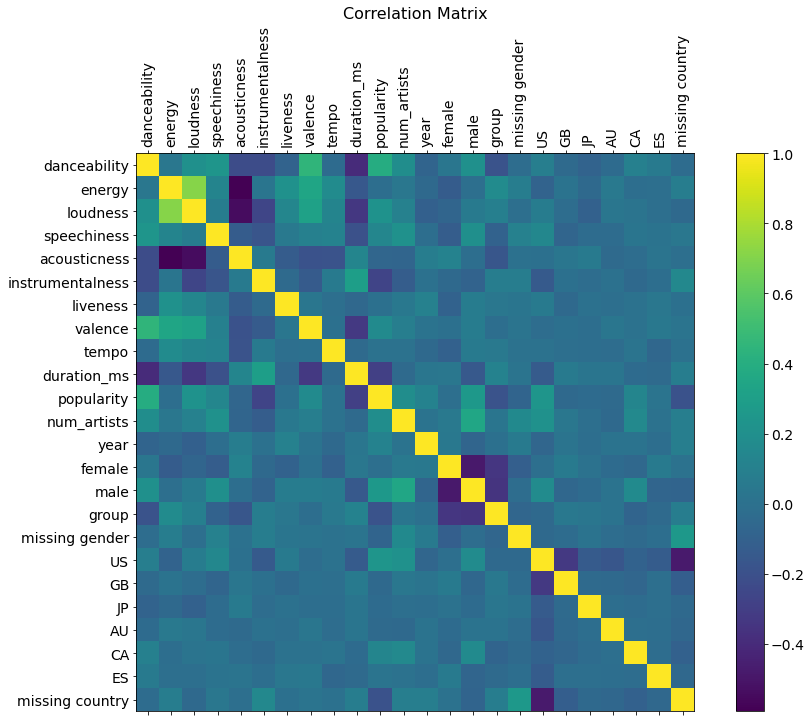

In [5]:
#Create dataframe with only numerical data
numerics=['int64', 'float64','bool']
df_num=df.drop(['born','group started'],axis=1).select_dtypes(include=numerics) 

#Plot correlation matrix
f = plt.figure(figsize=(15, 10))
plt.matshow(df_num.corr(),fignum=f.number)
plt.xticks(range(df_num.shape[1]), df_num.columns, fontsize=14, rotation=90)
plt.yticks(range(df_num.shape[1]), df_num.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

There are many things to look at in this plot, but let me highlight a few. The highest positive correlation (besides variables with themselves along the diagonal) appears to be between the loudness and the energy, which makes sense intuitively -- louder songs do usually have higher energy. Other high positive correlations include danceability and popularity, instrumentalness and duration, and missing gender and missing country. High negative correlations include acousticness and energy, duration and danceability, and duration and popularity. Note that these correlations do not allow us to make conclusions about the music industry as a whole. For example, the chart shows us that male and num_artists are highly correlated-- we can't say for certain that men in general have more collaborative songs. We can only say that songs by males that appear on top-songs-of-the-year lists are more likely to be collaborative. 

Now let's shift our attention to analyzing the differences between different music critic publications. We can define our null hypothesis to be that there is no statistical difference between the songs from each publication. To start our investigation, we'll see if we can plot our data and see a visual difference between songs listed by different publications. In order to do this, we will standardize our numerical data so that scaling does not affect the distribution, and then perform dimensionality reduction to get the data into two dimensions where we may take a look at it. We use Principal Component Analysis for our dimensionality reduction, as this is a standard technique that maintains the global structure of the data. For more information on PCA see [this article](https://towardsdatascience.com/a-one-stop-shop-for-principal-component-analysis-5582fb7e0a9c).

Text(0.5, 1.0, "PCA Of Dataframe (Music Publication's Top Songs 2018-2021)")

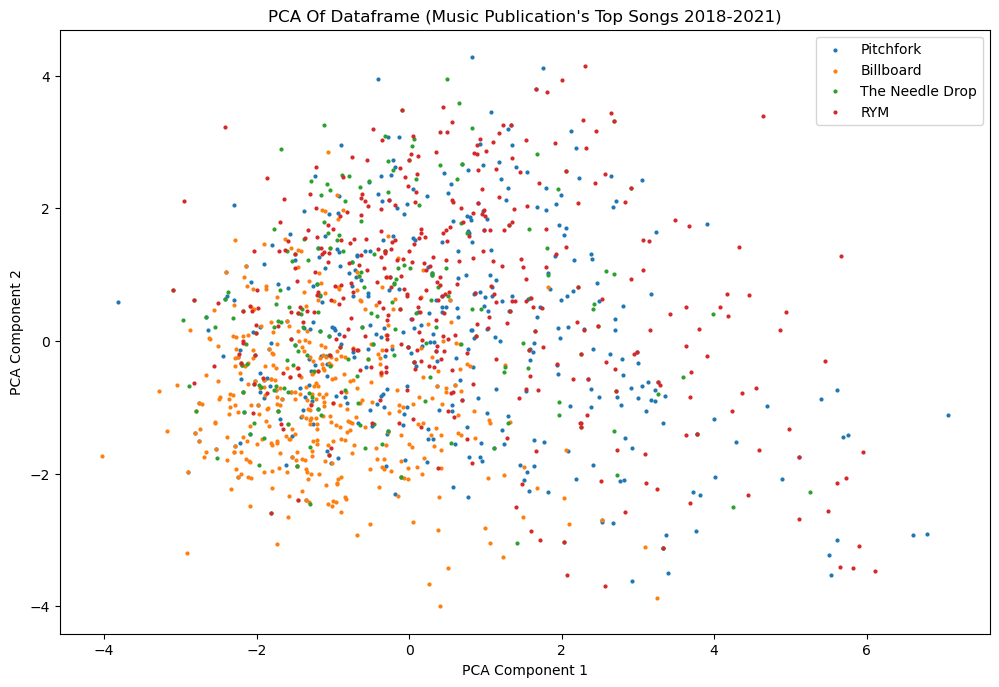

In [6]:
# Extract and standardize numerical data
df_arr=np.array(df_num) 
df_arr=StandardScaler().fit_transform(df_arr)

#Perform PCA with sklearn
pca = PCA(n_components=2)
pca_data = pca.fit_transform(df_arr)

# Plot PCA results by publication
fig,ax = plt.subplots(figsize=(12,8), dpi= 100)
pub_indices=[[] for pub in pubs]
for i,pub in enumerate(pubs):
    bool_series=df['publication']==pub
    pub_indices[i]=bool_series[bool_series].index.values
    ax.scatter(pca_data[pub_indices[i],0],pca_data[pub_indices[i],1],s=4)
    
ax.legend(labels=pubs)
ax.set_xlabel("PCA Component 1")
ax.set_ylabel("PCA Component 2")
plt.title('PCA Of Dataframe (Music Publication\'s Top Songs 2018-2021)')

From a glance at the PCA results, we can see that the different music publications have different distributions. A standout is Billboard, whose songs are relatively tightly compacted into the bottom left. RYM and Pitchfork, meanwhile, seem to have a much larger spread of songs, which align over much of the graph. The Needle Drop seems to be somewhere in the middle, with a distribution that isn't as broad as Pitchfork or RYM, but one that isn't as compact as Billboard. In the introduction, we mentioned that both RYM and The Needle Drop were criticized for overly preferring experimental music, yet here we can see that The Needle Drop's variance in top-songs-of-the-year picks is much smaller than RYM's. We also mentioned that Billboard top songs are criticized for being overly homogenous, which is supported by their small variance in the PCA representation.

We can use another dimensionality reduction technique, t-SNE, to better visualize the local topology of our data. You can read more about t-SNE [here](https://towardsdatascience.com/t-distributed-stochastic-neighbor-embedding-t-sne-bb60ff109561).

Text(0.5, 1.0, "t-SNE Projection Of Dataframe (Music Publication's Top Songs 2018-2021)")

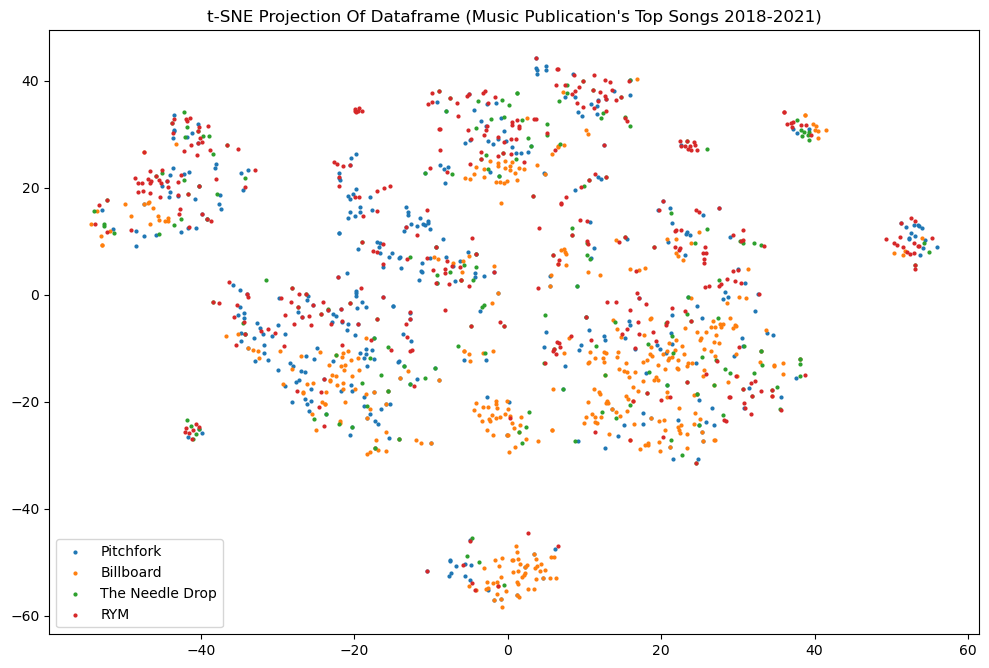

In [7]:
fig,ax = plt.subplots(figsize=(12,8), dpi= 100)
tnse=TSNE(init='random',learning_rate='auto')
tsne_data = tnse.fit_transform(df_arr)

pub_indices=[[] for pub in pubs]
for i,pub in enumerate(pubs):
    bool_series=df['publication']==pub
    pub_indices[i]=bool_series[bool_series].index.values
    ax.scatter(tsne_data[pub_indices[i],0],tsne_data[pub_indices[i],1],s=4)
    
ax.legend(labels=pubs)
plt.title('t-SNE Projection Of Dataframe (Music Publication\'s Top Songs 2018-2021)')

Similar to the results from PCA, we can see differences between the publications in the new space. What t-SNE shows us that is different is that the data forms certain clusters and each cluster contains a different proportion of each publication. Again, we see that RYM tends to align with Pitchfork, giving credence to the common criticism that Pitchfork tends to cater to the views of music fans as a whole.

Now let's look at some of the distributions of certain features in particular. We will format a few of them and then look at them one by one. We will start by looking at the popularity.

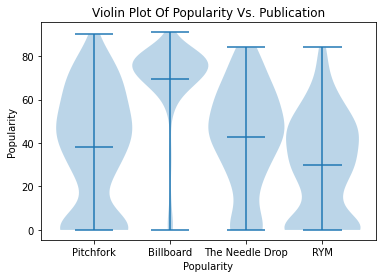

In [8]:
#Format violin plot data
pop_violin=[[] for pub in pubs]
born_violin=[[] for pub in pubs]
numartists_violin=[[] for pub in pubs]
for i,(publication,group) in enumerate(df.groupby(df['publication'],sort=False)):
    pop_violin[i]=list(group['popularity'])
    born_violin[i]=list(group['born'].dropna())
    numartists_violin[i]=list(group['num_artists'])

#Function for violin plot and labelling
def plot_violin(data,ylabel):
    fig, ax = plt.subplots()
    ax.violinplot(data,widths=1,showmeans=True)
    plt.xticks(range(1,5), pubs)
    ax.set_xlabel(ylabel)
    ax.set_ylabel("Popularity")
    ax.set_title("Violin Plot Of "+ylabel+" Vs. Publication")

plot_violin(pop_violin,"Popularity")

Billboard has the highest overall popularity by a large margin, which is a good sanity check. We do see that there is at least one song from Billboard with low popularity, which demonstrates that the Spotify data is not 100% reliable (artists having an album and a single version of the same song tends to interfere with the popularity metric). Pitchfork and RYM seem to have bimodal distributions, with one mode around 0, and the other around 40-50. Note that since the data that was missing was likely unpopular, both Pitchfork and RYM should have more songs with a lower popularity. The Needle Drop, while it lists some unpopular songs, has a higher average popularity than Pitchfork and RYM.

Now we take a look at the birth dates of artists by publication.

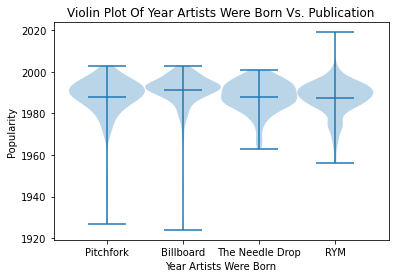

In [9]:
plot_violin(born_violin,"Year Artists Were Born")

From examining the plot we see that for every publication, the year the artists were born has a unimodal distribution that is skewed toward earlier years. Again, Billboard is different from the rest with a higher average birth year (aka its artists are younger). Apart from outliers, the other three publications have nearly the same distribution, with most artists being born in the 1990s and late 1980s, making the artists in their 20s and 30s when their song was listed. 

Now, we will look at the number of artists by publication.

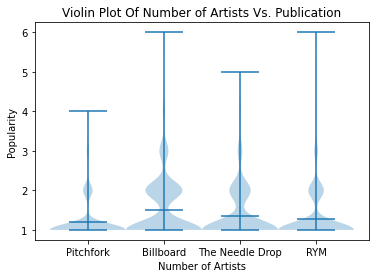

In [10]:
plot_violin(numartists_violin,"Number of Artists")

As we can see, nearly all the songs have three artists or fewer. Of the publications, Billboard has the highest number of two-artist and three-artist songs, followed by The Needle Drop, then RYM, and then Pitchfork. Pitchfork has a nearly negligible number of multi-artist songs.

## Hypothesis Testing

From our exploratory analysis, we have a good intuition that the different publications are statistically different from one another. Now let's test our hypotheses. We will say that we can reject a null hypothesis for a p-value of less than or equal to .05. For each publication and metric combination, we can compute a z-statistic between the publication's values for that metric and the values of that metric for all the other publications.  Using a z-table like the one [here](https://www.ztable.net/), we can see that a z-statistic of 1.96 corresponds to a two-tailed p-value of .05. Therefore, if any z-statistic for a publication and metric combo is greater than 1.96 or less than -1.96, we can reject the null hypothesis and conclude that the metric for this publication is statistically different from the metric for the other three publications. To see which metrics meet this threshold we will plot the z-statistics for each metric, publication combo along with +/-1.96 thresholds.

Text(0.5, 1.0, 'Z-statistic For Each Metric, Publication')

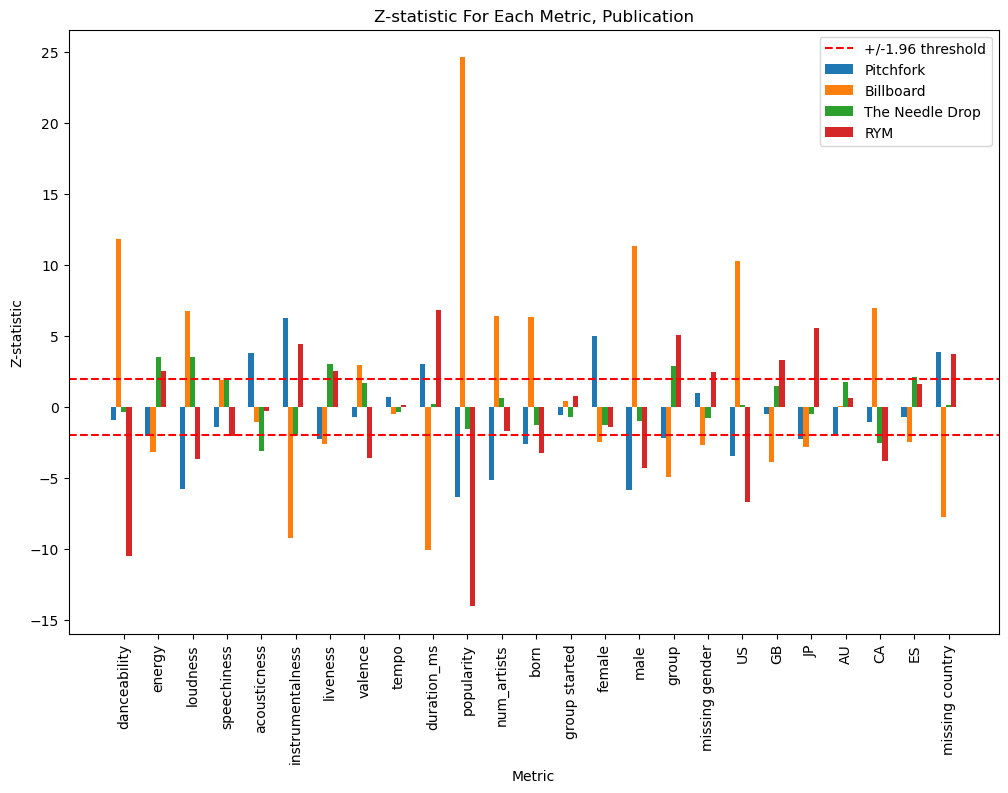

In [11]:
pub_zs=[[] for pub in pubs]
metrics=[]

#Iterate through datafram grouped by publication
for i,(publication,group) in enumerate(df.drop(['year'],axis=1).groupby(df['publication'],sort=False)):
    
    #Iterate through each metric
    for name,column in group.iteritems():
        if(column.dtype in numerics):
            if(i==0):
                metrics.append(name)

            #compute and store z-statistic
            z,p=ztest(column.dropna(),df[~(df['publication']==publication)][name].dropna())
            pub_zs[i].append(z)

#Plot results
fig,ax = plt.subplots(figsize=(12,8), dpi= 100)
bar_x=np.arange(len(metrics))
for i,pub_z_list in enumerate(pub_zs):
    ax.bar(bar_x+i*.15,pub_z_list,width=.15)
plt.xticks(bar_x+.3, metrics,rotation='vertical')
plt.axhline(y=1.96, color='r', linestyle='--')
plt.axhline(y=-1.96, color='r', linestyle='--',label='_nolegend_')
ax.legend(labels=['+/-1.96 threshold',*pubs])
ax.set_xlabel('Metric')
ax.set_ylabel('Z-statistic')
ax.set_title('Z-statistic For Each Metric, Publication')

Now it is clearly visible which metrics and publications have statistical differences. A portrait of each publication arises. When compared to the rest of the publications... 
* Top songs from Pitchfork are statistically more likely to 
     * be quieter
     * be more instrumental
     * be less popular
     * have fewer artists
     * have a female artist
     * not have a male artist
     * not have an artist from the US
* Top songs from Billboard are statistically more likely to 
    * be more danceable
    * be louder
    * be less instrumental
    * be shorter
    * be more popular
    * have more artists
    * have a male artist or an artist from the US and Canada
    * not have an artist who is a female, a group, or is from Britain, Japan, or Spain
* Top songs from The Needle Drop are statistically more likely to 
    * be more energetic
    * be less acoustic
    * be more live
    * have an artist who is a group
* Top songs from RYM are statistically more likely to 
    * be less danceable
    * be more instrumental
    * be longer
    * be less popular
    * not have an artist who is male or from the US or Canada
    * have an artist who is a group or is from Britain or Japan


If we revisit our small amount of missing data, likely our missing songs from RYM and Pitchfork would have boosted metrics like speechiness, male, and US, and decreased other metrics like popularity and danceability.

## Conclusions

Now that we have made our conclusions about Pitchfork, Billboard, The Needle Drop, and RYM, how can this information be used? 

For one, we have been able to evaluate quantitatively some of the criticisms of these publications: 
* Billboard top songs are criticized for being homogenous and the PCA representation, as well as the violin plots, broadly show that to be true.
* RYM and The Needle Drop are criticized for overly-preferring experimental music. For RYM this seems to be true, as we can see that in nearly every category it differs from public opinion as represented by Billboard, and it has a large variance across many different metrics. The Needle Drop, however, tends to lie in-between RYM and Billboard, indicating that its top songs are not too out of the mainstream when compared to the rest of the music critic industry.
* Pitchfork is criticized for catering too heavily to music fans, which is supported by the fact that they seem to align with RYM which can represent the views of music fans

Hopefully, fans can use this information to better guide the conversation around the music critic landscape, referencing these numbers to amplify the complaints that seem correct and attenuate those that don't. 

We also now have a better overall picture of each publication, which can be used by several parties:
* Fans can better understand the tendencies of each publication, and follow those that more closely follow their preferences. 
* The publications themselves can better understand how they compare to their counterparts and perhaps make adjustments to what could be perceived as a bias or blindspot.
* Labels can cater their promotions better so that they are promoting the right artists to the right publications, or perhaps see where they could promote different types of artists more

There are several other areas of investigation to pursue stemming from this article. In the future, I'd like to:
* Detect whether the pairwise correlations are different by publication
* Investigate what unifies the clusters from the t-SNE results
* Include other publications like Rolling Stone, NPR music, and Stereogum
* Find songs that all publications rated and analyze the scores that were given by each
* For publications like The Needle Drop and Pitchfork that can only review a limited number of albums, analyze which ones were given a review at all
* Analyze the record label composition, and the budget associated with each label to see how budget and label membership effects a publication's rating
* Include music genres in the analysis

The results from this article are also important because the music critic industry seems underexplored. Despite the wealth of available data, the amount of conversation on the web about these different publications, and the importance of the music critic industry to the music itself, I have been unable to find a single article analyzing the quantitative differences between music critics. Just as music criticism seeks to give fans a clearer perspective in which to see new music, hopefully data science can give fans a clearer perspective in which to see music critics.